In [21]:
#pip install tensorflow

In [22]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [23]:
df = pd.read_excel("updated_dataset_final - Copy.xlsx", parse_dates=['TANGGAL']) #parse = untuk ngubah kolom tanggal jadi datetime
df = df.sort_values('TANGGAL')
df = df.reset_index(drop=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  4013 non-null   datetime64[ns]
 1   TN       4013 non-null   float64       
 2   TX       4013 non-null   float64       
 3   TAVG     4013 non-null   float64       
 4   RH_AVG   4013 non-null   float64       
 5   RR       4013 non-null   float64       
 6   SS       4013 non-null   float64       
 7   FF_X     4013 non-null   int64         
 8   DDD_X    4013 non-null   int64         
 9   FF_AVG   4013 non-null   int64         
 10  DDD_CAR  4013 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 345.0 KB


In [25]:
df.tail(5)

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
4008,2025-11-26,26.4,34.8,29.9,64.0,0.0,6.4,3,240,1,0
4009,2025-11-27,26.6,32.8,29.4,70.0,0.0,3.5,4,300,1,0
4010,2025-11-28,26.8,32.5,30.0,66.0,0.0,3.0,4,340,1,0
4011,2025-11-29,27.2,33.0,29.2,71.0,0.0,2.9,4,290,2,0
4012,2025-11-30,27.2,32.6,29.3,70.0,1.0,4.8,6,90,2,0


In [26]:
def add_safe_features(df):
    df = df.copy()

    # Extract month and day in tanggal column
    df['month'] = df['TANGGAL'].dt.month
    df['day']   = df['TANGGAL'].dt.day

    # Create coordinat cos dan sin menggunakan rumus  
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['day_sin']   = np.sin(2*np.pi*df['day']/31)
    df['day_cos']   = np.cos(2*np.pi*df['day']/31)

    df['temp_range'] = df['TX'] - df['TN']

    # def month_to_season(m):
    #     if m in [12,1,2]: return 1
    #     elif m in [3,4,5]: return 2
    #     elif m in [6,7,8]: return 3
    #     else: return 4
    # df['season'] = df['month'].apply(month_to_season)

    return df

df = add_safe_features(df)


In [27]:
# Opsi 1: Split dengan proporsi lebih seimbang
train = df[df['TANGGAL'] < '2024-01-01']  # 2015-2023 (9 tahun)
val   = df[(df['TANGGAL'] >= '2024-01-01') & (df['TANGGAL'] < '2024-07-01')]  # 6 bulan
test  = df[(df['TANGGAL'] >= '2024-07-01') & (df['TANGGAL'] < '2025-01-01')]  # 6 bulan
# Sisanya (2025) untuk production forecast

print(f"Train: {len(train)} samples")
print(f"Val: {len(val)} samples")
print(f"Test: {len(test)} samples")

Train: 3303 samples
Val: 182 samples
Test: 184 samples


In [28]:
#df.info()

In [29]:
def add_leakage_safe_lags(train, val, test):
    # Digabung, tapi rolling hanya dari bagian TRAIN
    full = pd.concat([train, val, test], axis=0)

    
    #Ambil data hujan sehari sebelum dan 
    full['RR_lag1']  = full['RR'].shift(1)
    full['RR_lag2'] = full['RR'].shift(2)
    full['RR_lag3'] = full['RR'].shift(3)
    full['RR_lag7']  = full['RR'].shift(7)
    full['TAVG_lag1'] = full['TAVG'].shift(1)

    full['RR_diff1'] = full['RR'] - full['RR_lag1']
    full['RH_diff1'] = full['RH_AVG'] - full['RH_AVG'].shift(1)

    full['RR_7d']  = full['RR'].rolling(7).mean()
    full['RR_14d'] = full['RR'].rolling(14).mean()
    full['RR_30d'] = full['RR'].rolling(30).mean()

    full['Rain_7d_count'] = full['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7).sum()

    # Setelah fitur selesai → split kembali
    train2 = full.loc[train.index]
    val2   = full.loc[val.index]
    test2  = full.loc[test.index]

    return train2, val2, test2

train, val, test = add_leakage_safe_lags(train, val, test)


In [30]:
train = train.dropna()
val   = val.dropna()
test  = test.dropna()


In [31]:
features = [
    'TN','TX','TAVG','RH_AVG','SS','FF_X','DDD_X','FF_AVG','DDD_CAR',
    'RR_lag1','RR_lag2','RR_lag3', 'RR_lag7','TAVG_lag1','RR_diff1','RH_diff1',
    'RR_7d', 'RR_14d','RR_30d','Rain_7d_count',
    'month_sin','month_cos','day_sin','day_cos','temp_range'
]

X_train = train[features]
y_train = train['RR']

X_val = val[features]
y_val = val['RR']

X_test = test[features]
y_test = test['RR']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [32]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)
xgb.fit(X_train_scaled, y_train)

pred_xgb = xgb.predict(X_val_scaled)

print("XGB MAE:", mean_absolute_error(y_val, pred_xgb))

#XGB MAE: 0.7026166778040924


XGB MAE: 0.7866909274021674


In [33]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

pred_rf = rf.predict(X_val_scaled)


mse = mean_squared_error(y_val, pred_rf)      # default mengembalikan MSE
rmse = np.sqrt(mse)
print("RF MAE:", mean_absolute_error(y_val, pred_rf))
print("RF RMSE:", rmse)

#RF MAE: 0.5942667449238894
#RF RMSE: 1.500483658715626

RF MAE: 0.7537669153178763
RF RMSE: 1.6584435194507514


In [34]:
# reshape → (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [35]:
# Create proper sequences for LSTM
def create_sequences(X, y, seq_length=7):
    """Create sequences of seq_length timesteps"""
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y.iloc[i+seq_length])
    return np.array(Xs), np.array(ys)

# Create sequences
seq_length = 7  # Gunakan 7 hari history
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, seq_length)

print(f"LSTM input shape: {X_train_seq.shape}")  # (samples, 7, features)

# ✅ Proper LSTM architecture
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, X_train_scaled.shape[1])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),  # ✅ Stacked LSTM
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# ✅ Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

pred_lstm = model.predict(X_val_seq)
print("LSTM MAE:", mean_absolute_error(y_val_seq, pred_lstm))

LSTM input shape: (3267, 7, 25)


c:\Users\Lenovo E15\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 273.8917 - mae: 6.9976 - val_loss: 340.1819 - val_mae: 9.4946
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 249.5752 - mae: 7.4958 - val_loss: 338.0749 - val_mae: 8.5762
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 241.4108 - mae: 7.2890 - val_loss: 322.4618 - val_mae: 8.3202
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 234.7360 - mae: 7.1865 - val_loss: 321.1545 - val_mae: 8.1090
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 230.0070 - mae: 7.0863 - val_loss: 311.2694 - val_mae: 8.4971
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 224.3170 - mae: 6.9778 - val_loss: 328.6270 - val_mae: 7.8106
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 216.9319 - mae: 6.8245 - val_loss: 312.9190 - val_mae: 7.9059
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 210.1726 - mae: 6.7847 - val_loss: 318.1635 - val_mae: 8.7903
Epoch 9/

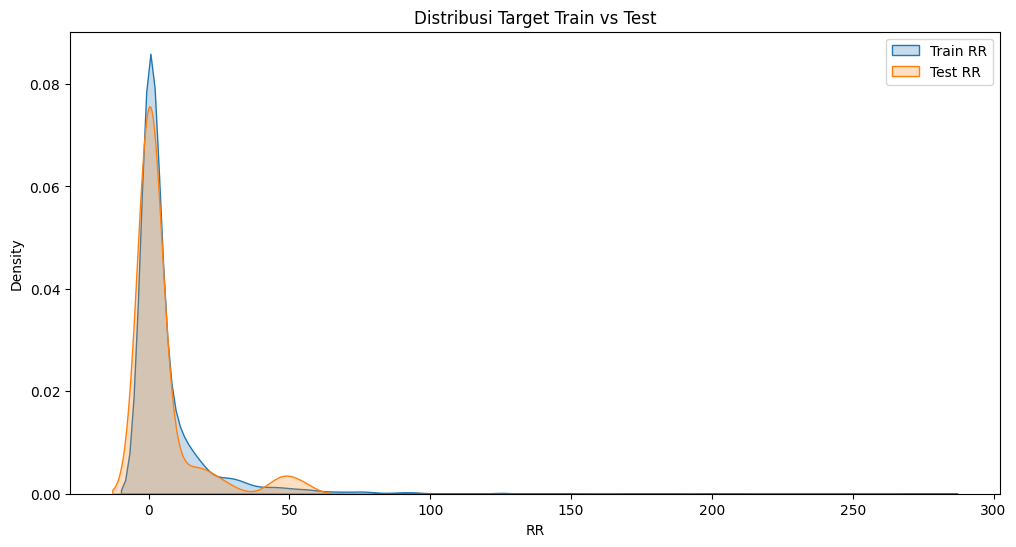

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.kdeplot(y_train, label='Train RR', fill=True)
sns.kdeplot(y_test, label='Test RR', fill=True)
plt.title("Distribusi Target Train vs Test")
plt.legend()
plt.show()


In [37]:
import pandas as pd
import numpy as np

corr = pd.concat([X_train, y_train], axis=1).corr()
target_corr = corr['RR'].sort_values(ascending=False)

print("Korelasi Fitur dengan Target:")
print(target_corr)


Korelasi Fitur dengan Target:
RR               1.000000
RR_diff1         0.630054
RR_7d            0.488228
RH_AVG           0.397900
RR_14d           0.392493
RR_30d           0.343710
Rain_7d_count    0.273764
RR_lag1          0.205826
month_sin        0.194030
RR_lag2          0.144035
month_cos        0.132766
DDD_X            0.103375
RR_lag7          0.100568
RR_lag3          0.099001
RH_diff1         0.044484
DDD_CAR          0.012741
FF_X             0.011858
FF_AVG           0.001426
day_cos         -0.000207
day_sin         -0.011507
temp_range      -0.059098
SS              -0.195308
TAVG_lag1       -0.311649
TX              -0.321259
TAVG            -0.389429
TN              -0.392595
Name: RR, dtype: float64


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred_train_rf = rf.predict(X_train_scaled)
pred_test_rf = rf.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, pred_train_rf))
test_rmse  = np.sqrt(mean_squared_error(y_test, pred_test_rf))

train_mae = mean_absolute_error(y_train, pred_train_rf)
test_mae  = mean_absolute_error(y_test, pred_test_rf)

print("RF Train RMSE:", train_rmse)
print("RF Test RMSE :", test_rmse)
print("RF Train MAE:", train_mae)
print("RF Test MAE :", test_mae)


RF Train RMSE: 1.7571655046763552
RF Test RMSE : 1.3465549814521787
RF Train MAE: 0.333738546871672
RF Test MAE : 0.48299955755470114


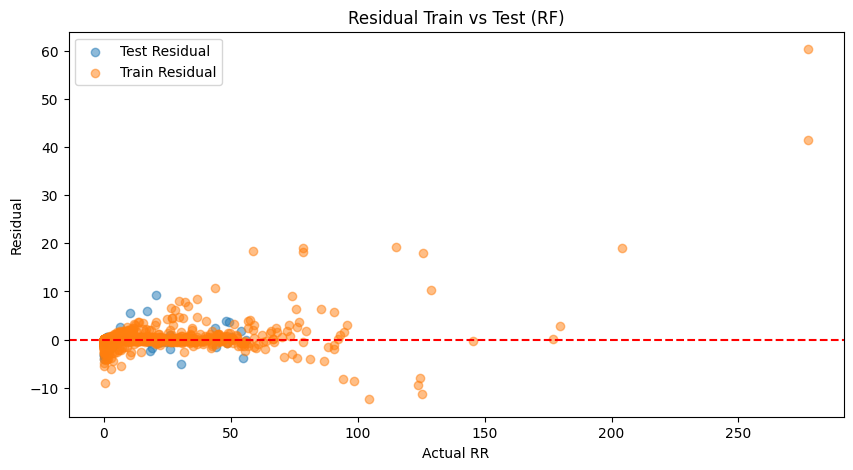

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_test - pred_test_rf, alpha=0.5, label="Test Residual")
plt.scatter(y_train, y_train - pred_train_rf, alpha=0.5, label="Train Residual")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual RR")
plt.ylabel("Residual")
plt.legend()
plt.title("Residual Train vs Test (RF)")
plt.show()


# Predict Future (Forecast)

In [40]:
def build_future_features(history_df, future_date):
    """
    Build features for future prediction WITHOUT data leakage
    HANYA gunakan: lag features, rolling stats, dan time features
    """
    history_df = history_df.copy()
    future_date = pd.to_datetime(future_date)

    # Buat row baru dengan HANYA time features
    base = pd.Series(dtype='float64')
    base['TANGGAL'] = future_date

    # Date features (AMAN - kita tahu tanggal masa depan)
    base['month'] = future_date.month
    base['day'] = future_date.day
    base['month_sin'] = np.sin(2*np.pi*base['month']/12)
    base['month_cos'] = np.cos(2*np.pi*base['month']/12)
    base['day_sin'] = np.sin(2*np.pi*base['day']/31)
    base['day_cos'] = np.cos(2*np.pi*base['day']/31)

    # TIDAK ADA fitur TN, TX, TAVG, RH_AVG karena tidak diketahui!
    # Kita hanya bisa gunakan LAG dan ROLLING dari data historis

    # Untuk menghitung lag features, gabungkan dengan history
    temp = pd.concat([history_df.tail(30), pd.DataFrame([base])], ignore_index=True)

    # Lag features - ini yang kita tahu dari history
    temp['RR_lag1'] = temp['RR'].shift(1)
    temp['RR_lag2'] = temp['RR'].shift(2)
    temp['RR_lag3'] = temp['RR'].shift(3)
    temp['RR_lag7'] = temp['RR'].shift(7)
    temp['TAVG_lag1'] = temp['TAVG'].shift(1)

    temp['RR_diff1'] = temp['RR'] - temp['RR_lag1']
    temp['RH_diff1'] = temp['RH_AVG'] - temp['RH_AVG'].shift(1)

    temp['RR_7d'] = temp['RR'].rolling(7, min_periods=1).mean()
    temp['RR_14d'] = temp['RR'].rolling(14, min_periods=1).mean()
    temp['RR_30d'] = temp['RR'].rolling(30, min_periods=1).mean()

    temp['Rain_7d_count'] = temp['RR'].apply(lambda x: 1 if x > 0 else 0).rolling(7, min_periods=1).sum()

    # PENTING: Tambahkan temp_range HANYA jika Anda punya forecast TX dan TN
    # Jika tidak, HAPUS fitur ini dari list features
    # temp['temp_range'] = temp['TX'] - temp['TN']  # ❌ Jangan gunakan!

    return temp.iloc[-1:]

In [41]:
def forecast_7_days(
    df,
    start_date,
    features,
    scaler,
    rf,
    xgb,
    lstm_model
):
    history = df.copy()
    results = []

    current_date = pd.to_datetime(start_date)

    for i in range(7):
        next_date = current_date + pd.Timedelta(days=1)

        future_row = build_future_features(history, next_date)
        future_scaled = scaler.transform(future_row[features])

        # Predictions
        pred_rf  = rf.predict(future_scaled)[0]
        pred_xgb = xgb.predict(future_scaled)[0]
        pred_lstm = lstm_model.predict(
            future_scaled.reshape(1,1,-1)
        )[0][0]

        # Ensemble simple (optional)
        pred_mean = np.mean([pred_rf, pred_xgb, pred_lstm])

        results.append({
            "Tanggal": next_date,
            "RF": pred_rf,
            "XGB": pred_xgb,
            "LSTM": pred_lstm,
            "Ensemble": pred_mean
        })

        # Append prediction as RR
        new_row = future_row.copy()
        new_row['RR'] = pred_mean   # gunakan ensemble
        history = pd.concat([history, new_row], ignore_index=True)

        current_date = next_date

    return pd.DataFrame(results)


In [42]:
future_7d = forecast_7_days(
    df=df,
    start_date="2025-12-01",
    features=features,
    scaler=scaler,
    rf=rf,
    xgb=xgb,
    lstm_model=model
)

print(future_7d)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
     Tanggal        RF         XGB      LSTM   Ensemble
0 2025-12-02  0.005888   92.323708  0.114357  30.814651
1 2025-12-03  0.573285  110.860687  0.114357  37.182777
2 2025-12-04  0.855303  109.466896  0.114357  36.812185
3 2025-12-05  2.169145  110.604324  0.114357  37.629276
4 2025-12-06  2.514911  114.244133  0.114357  38.957800
5 2025-12-07  3.718992  123.670166  0.114357  42.501172
6 2025-12-08  6.117281  125.825905  0.114357  44.019181
